### Basics-

1) Tokens are numerical mappings of the text. They can be characters, sub-words, combinations of characters and subwords, etc
    When tokenizing text,  each sentence will be 1 batch. If you want multiple batches, create a list of sentences
2) Embeddings are vector space representations of tokens. An embdedding space essentially has a mapping of tokens to embeddings (vectors) through a logic-
    - Embedding layer syntax: nn.Embedding(num_embeddings=vocab_size, embedding_dim= embedding_dim)
    - Here, we define the embedding dimensions, i.e to what dimension we want to map our text- and we generally call it hidden size as it is the dimension of the space that is hidden from the user
    - Vocab size is also defined by us if we use a custom tokenizer, but a standard one will already have a vocab_size mapped
3) Scaled Dot product attention
4) Single head attention-
- What is independent attention mechanism?
    - It is a projection of the input embeddings into a low dimension space represented by head_dim, and it learns one specific feature of the sequence (like subject verb, active passive etc)

5) Multihead attention
    - each attention head has a linear mapping from embedding dimensions to head dimensions
    - This mapping is done on the entire sequence of embedded tokens in each batch
    - We use this mapped value (of q,v and k) from the head and compute the similarity between the query and the key and then scale it using softmax
    - Q represents the query, i.e the token for which we require context (What we want?)
    - Key represents all the other tokens in the embedding (What we have?)
    - Value represents the exact information represented by each token (What information is to be returned based on similarity between query and key?)
    - We use this scaled dot product (attention scores) to take a dot product with the value and give us the updated embeddings that essentially give us the original embedding including some context of the past and future sequence
    - After calculating the updated values for one head, we repeat for all heads and then concatenate all heads along the last dimension, which is the head dimension. When we concatenate, we get the original embedding space back, but with added context. we get output with dimensions [batch, sequence, embedding dimensions]

  
6) After getting the output of multihead attention, we first create a transformer encoder layer. First, we add a residual connection (by adding multihead output to original string embeddings)
7) We then do a layer normalization (since we did addition) to bring back the embeddings to mean 0. We also stabilize the data for training so that there are no vanishing gradients
8) After this, each token embedding goes through a feed forward network
    - First mapping is from hidden dimensions (input embedding dimensions) to intermediate dimensions (larger space) to capture nuances
    - Next we apply ReLU activation to introduce non linearity to learn complex relationship. If we don't do this, the entire attention model will be based on linear transformations
    - The last mapping is converting the input embeddings in intermediate dimension back to the original dimensions (we basically assume that the transformations will incorporate the patterns and relations learned in the higher dimensional space
9) We again perform a residual connection (adding feed forward output to original embeddings) and layer normalization
    
10) After creating the transformer encoder layer, we create a transformer encoder, for which we would need to add positional embeddings so that the transformer knows the position of a particular embedding in a sequence, which can allow it to learn more relations
    - To add positional embeddings, we need a way to engineer values such that they are normalized and unique
    - We use cos and sin approach for odd and even index values respectively
    - Before using the cos and sin functions, we need to calculate a unique normalized number for each position. We create a divisor for all even numbers (we can do it only for odd as well but we don't need to do for both as sin and cos phase shift would take care of it)
    - Note that we use cos and sin functions on a multiplication  of divisor with the absolute position (somewhere betwen 0 to max length)
    - After adding the cos and sin functions to create positional embeddings, we add it to a buffer so that it doesnt change when model is being trained (as this function will be called multiple times)
    - We then add these positional embeddings to the original input embedding vector
    - It is definitely mind boggling, I don't get how adding two vectors would help the algo figure out a position. But it seems to be working


In [64]:
from torch import nn
from transformers import AutoTokenizer, AutoConfig
import torch
import torch.nn.functional as F
from math import sqrt
import math
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# device= "cuda"

# Encoder

In [63]:
# Tokenization

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
text = 'I love data science.'
text2= 'I like machine learning.'
print(tokenizer([text, text2], add_special_tokens=False, return_tensors='pt'))
inputs = tokenizer([text, text2], add_special_tokens=False, return_tensors='pt')

{'input_ids': tensor([[1045, 2293, 2951, 2671, 1012],
        [1045, 2066, 3698, 4083, 1012]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}


In [3]:
# Embedding configurations
config= AutoConfig.from_pretrained('bert-base-uncased')
print(config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [4]:

token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
print(token_embeddings)

Embedding(30522, 768)


In [5]:
input_embeds= token_embeddings(inputs.input_ids)
print(input_embeds.size())

torch.Size([2, 5, 768])


In [6]:
## Calculating Attention Scores

#query = key = value = input_embeds

# function to calculate attention weights that are used to produce updated embeddings
def scaled_dot_product_attention(query,key, value, mask=None):
    dim_k = query.size(-1)

    # attention scores; each element represents the similarity between tokens via dot product, and the output is scaled by root(dimension of key) so as to keep the dot product less and training stable
    scores= torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
            
    weights = F.softmax(scores, dim= -1)
    updated_embeddings= torch.bmm(weights, value)
    return updated_embeddings

# these updated embeddings actually account for all the tokens in that sequence other than the token at that position
# updated_embeddings= scaled_dot_product_attention(query,key,value)
# print(updated_embeddings.size())

In [7]:
## Single attention head

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)
    
    def forward(self, hidden_state, mask=None):
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state), self.k(hidden_state), self.v(hidden_state), mask)
        return attn_outputs
 

In [8]:
## Multi attention head

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList([AttentionHead(embed_dim, head_dim) for _ in range(num_heads)])
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, hidden_state, mask=None):
        # This concatenation is happening on the last dimension for all heads, which basically means we are getting back to the embedding dimensions
        x = torch.cat([h(hidden_state, mask) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

In [9]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         embed_dim = config.hidden_size
#         num_heads = config.num_attention_heads
#         self.head_dim = embed_dim // num_heads
#         self.num_heads = num_heads
        
#         # Linear projections for queries, keys, and values
#         self.q_proj = nn.Linear(embed_dim, embed_dim)
#         self.k_proj = nn.Linear(embed_dim, embed_dim)
#         self.v_proj = nn.Linear(embed_dim, embed_dim)
        
#         # Final linear layer
#         self.output_linear = nn.Linear(embed_dim, embed_dim)
    
#     def scaled_dot_product_attention(self, query, key, value, mask=None):
#         dim_k = query.size(-1)
#         scores = torch.matmul(query, key.transpose(-2, -1)) / sqrt(dim_k)  # Calculate attention scores
        
#         # Apply the mask, if provided
#         if mask is not None:
#             scores = scores.masked_fill(mask == 0, float('-inf'))
        
#         # Calculate attention weights and apply to value
#         attn_weights = F.softmax(scores, dim=-1)
#         output = torch.matmul(attn_weights, value)
#         return output
    
#     def forward(self, query, key, value, mask=None):
#         batch_size = query.size(0)
        
#         # Linear projections and reshaping for multi-head attention
#         query = self.q_proj(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
#         key = self.k_proj(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
#         value = self.v_proj(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
#         # Scaled dot-product attention
#         attn_output = self.scaled_dot_product_attention(query, key, value, mask=mask)  # Ensure mask is passed as keyword argument
        
#         # Concatenate attention output from each head and apply final linear layer
#         attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
#         output = self.output_linear(attn_output)
        
#         return output


In [10]:
# Transformer Encoding Layer to incorporate more context and non linearity

class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.multihead_attn = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.hidden_size)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(config.hidden_size, config.intermediate_size),
            nn.ReLU(),
            nn.Linear(config.intermediate_size, config.hidden_size),
        )
        
        self.layer_norm2 = nn.LayerNorm(config.hidden_size)
    
    def forward(self, hidden_state):
        # Multi-head attention with residual connection and layer normalization
        attn_output = self.multihead_attn(hidden_state)
        hidden_state = self.layer_norm1(hidden_state + attn_output)
        
        # Feed-forward network with residual connection and layer normalization
        ffn_output = self.feed_forward(hidden_state)
        hidden_state = self.layer_norm2(hidden_state + ffn_output)
        
        return hidden_state


In [11]:
# Positional Encoding

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()
        
        # Create a large positional encoding matrix of shape (max_len, embed_dim)
        # Convert a consecutive list of numbers to column matrix
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register buffer so it doesn't get updated during backpropagation
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input tensor
        x = x + self.pe[:x.size(1), :].unsqueeze(0)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Positional encoding will be added before passing inputs to layers
        self.positional_encoding = PositionalEncoding(config.hidden_size, config.max_position_embeddings)
        
        # Stack of encoder layers
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_state, src_mask= None):
        # Add positional encoding to input embeddings
        hidden_state = self.positional_encoding(hidden_state)
        
        # Pass through each encoder layer in the stack
        for layer in self.layers:
            hidden_state = layer(hidden_state)
        
        return hidden_state


In [12]:
# # Instantiate the encoder with the configuration
# encoder = TransformerEncoder(config)

# # Pass the initial embeddings through the encoder
# encoder_output = encoder(input_embeds)

# print(encoder_output.size())  # Expected output: [batch size, sequence length, embedding dimension]


# Decoder

In [13]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        
        # Masked self-attention for the decoder
        self.self_attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        
        # Encoder-decoder attention
        self.encoder_attention = MultiHeadAttention(config)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, config.intermediate_size),
            nn.ReLU(),
            nn.Linear(config.intermediate_size, embed_dim)
        )
        self.layer_norm3 = nn.LayerNorm(embed_dim)

    def forward(self, hidden_state, encoder_output, tgt_mask=None, memory_mask=None):
        # Masked self-attention: attends to previous tokens only
        attn_output = self.self_attention(hidden_state, mask=tgt_mask)
        hidden_state = self.layer_norm1(hidden_state + attn_output)
        
        # Encoder-decoder attention: attends to the encoder's output
        enc_dec_attn_output = self.encoder_attention(hidden_state, encoder_output, encoder_output, mask=memory_mask)
        hidden_state = self.layer_norm2(hidden_state + enc_dec_attn_output)
        
        # Feed-forward network
        ffn_output = self.feed_forward(hidden_state)
        hidden_state = self.layer_norm3(hidden_state + ffn_output)
        
        return hidden_state


In [14]:
class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.positional_encoding = PositionalEncoding(config.hidden_size, config.max_position_embeddings)
        self.layers = nn.ModuleList([TransformerDecoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, tgt_embeds, encoder_output, tgt_mask=None, memory_mask=None):
        # Add positional encoding to the target embeddings
        hidden_state = self.positional_encoding(tgt_embeds)
        
        # Pass through each decoder layer
        for layer in self.layers:
            hidden_state = layer(hidden_state, encoder_output, tgt_mask=tgt_mask, memory_mask=memory_mask)
        
        return hidden_state


In [15]:
class TransformerForSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, vocab_size, hidden_size):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.embedding = nn.Embedding(vocab_size, hidden_size)  # Embedding layer to map token IDs to embeddings
        self.output_linear = nn.Linear(hidden_size, vocab_size)  # Final linear layer to predict token logits

    def forward(self, src_ids, tgt_ids, src_mask=None, tgt_mask=None, memory_mask=None):
        # Apply embedding layer to convert token IDs to embeddings
        src_embeds = self.embedding(src_ids)  # Shape: [batch size, src_seq_len, hidden_size]
        tgt_embeds = self.embedding(tgt_ids)  # Shape: [batch size, tgt_seq_len, hidden_size]
        
        # Pass through encoder and decoder
        encoder_output = self.encoder(src_embeds, src_mask)
        decoder_output = self.decoder(tgt_embeds, encoder_output, tgt_mask, memory_mask)
        
        # Project decoder output to vocabulary size for logits
        logits = self.output_linear(decoder_output)
        
        return logits


# Next Few Word Prediction Using GPT 2

In [16]:
# def remove_non_ascii(input_file, output_file):
#     try:
#         with open(input_file, 'r', encoding='utf-8') as file:
#             text = file.read()
        
#         # Removing non-ASCII characters
#         cleaned_text = ''.join([char if ord(char) < 128 else '' for char in text])
        
#         # Writing cleaned content to output file
#         with open(output_file, 'w', encoding='utf-8') as file:
#             file.write(cleaned_text)
        
#         print(f"Non-ASCII characters removed. Cleaned file saved as: {output_file}")
#     except Exception as e:
#         print(f"An error occurred: {e}")

# # Specify the input and output files
# input_file = './Datasets/chat_temp.txt'  # Replace this with your actual input file path
# output_file = './Datasets/output_transformer_temp.txt' # Replace this with your desired output file path

# # Run the function
# remove_non_ascii(input_file, output_file)


In [3]:
with open('./Datasets/output_transformer_temp.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
lines=[line.strip() for line in lines] 

lines[:10]

['Lukha Saala: Bhau',
 'Lukha Saala: Bhai',
 'Lukha Saala: Thik hai tu?',
 'Irish Mehta: Tensor flow kar raha',
 'Irish Mehta: Regression seekha',
 'Irish Mehta: Edureka hi kar raha hu',
 'Lukha Saala: Kidhar se kiya?',
 'Lukha Saala: Acha oh',
 'Lukha Saala: Abe aag lagi n vaha pe?',
 'Irish Mehta: Ha koi coaching mein lagi']

In [4]:
for input_seq, target_word in dataloader:
    # Decode input sequence and target word for visualization
    input_text = tokenizer.decode(input_seq[1].tolist(), skip_special_tokens=True)
    target_text = tokenizer.decode([target_word[1].item()], skip_special_tokens=True)
    
    print("Input Sequence (decoded):", input_text)
    print("Target Word (decoded):", target_text)
    # Display only the first batch for verification


Input Sequence (decoded): Irish Mehta:
Target Word (decoded):  B
Input Sequence (decoded): Lukha Sa
Target Word (decoded): ala
Input Sequence (decoded): Lukha Sa
Target Word (decoded): ala
Input Sequence (decoded): Irish Me
Target Word (decoded): ht
Input Sequence (decoded): Irish Mehta: Call
Target Word (decoded):  k
Input Sequence (decoded): Irish Me
Target Word (decoded): ht
Input Sequence (decoded): Irish
Target Word (decoded):  Me
Input Sequence (decoded): ally is expected to see a high growth phase on account of enhanced technology adoptions.
Target Word (decoded):  The
Input Sequence (decoded): lCoYmTk1%40thread.tacv2/1669709970798?context=%7b%22Tid%22%3a%22084a029e-1435-40bc-8201-87ec1b251fb3
Target Word (decoded): %
Input Sequence (decoded): Lukha Sa
Target Word (decoded): ala
Input Sequence (decoded): Lukha Saala: https://github.com/terminator
Target Word (decoded): ash
Input Sequence (decoded): Lukha Saala: Le
Target Word (decoded): et
Input Sequence (decoded): Irish
Target 

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

class NextWordDataset(Dataset):
    def __init__(self, lines, tokenizer, max_length=30):  # Changed sentences to lines
        self.tokenizer = tokenizer
        self.samples = []
        self.max_length = max_length

        for line in lines:  # Changed sentence to line
            tokens = tokenizer.encode(line, add_special_tokens=False)
            
            for i in range(1, len(tokens)):
                input_seq = tokens[:i]
                target_word = tokens[i]
                
                input_seq = input_seq[-self.max_length:]
                input_seq = [tokenizer.bos_token_id] + input_seq
                input_seq_tensor = torch.tensor(input_seq, dtype=torch.long)
                target_tensor = torch.tensor(target_word, dtype=torch.long)

                self.samples.append((input_seq_tensor, target_tensor))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=tokenizer.pad_token_id)
    targets = torch.stack(targets)
    return inputs_padded, targets

# Create dataset and dataloader
dataset = NextWordDataset(lines, tokenizer, max_length=60)  # Using lines instead of sentences
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Setup model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

# Training configuration
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 100
model.train()
epoch_losses = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (input_seq, target_word) in enumerate(dataloader):
        input_seq = input_seq.to(device)
        target_word = target_word.to(device)

        # Forward pass
        outputs = model(input_ids=input_seq)
        logits = outputs.logits
        
        # Get predictions for the last token in each sequence
        last_token_logits = logits[:, -1, :]  # Shape: [batch_size, vocab_size]
        
        # Calculate loss for next token prediction
        loss = F.cross_entropy(last_token_logits, target_word)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 1000 == 0:  # Print progress every 10 batches
            print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")


Epoch 1, Batch 0, Loss: 59.2265
Epoch 1, Batch 1000, Loss: 3.0093
Epoch 1, Batch 2000, Loss: 5.9985
Epoch 1, Batch 3000, Loss: 2.3907
Epoch 1, Batch 4000, Loss: 2.8583
Epoch 1, Batch 5000, Loss: 3.7206
Epoch 1, Batch 6000, Loss: 4.3912
Epoch 1, Batch 7000, Loss: 3.0503
Epoch 1, Batch 8000, Loss: 3.5914
Epoch 1, Batch 9000, Loss: 3.0195
Epoch 1, Batch 10000, Loss: 2.2574
Epoch 1, Batch 11000, Loss: 2.5765
Epoch 1/100, Average Loss: 3.0608
Epoch 2, Batch 0, Loss: 3.2441
Epoch 2, Batch 1000, Loss: 3.4051
Epoch 2, Batch 2000, Loss: 2.2819
Epoch 2, Batch 3000, Loss: 2.4163
Epoch 2, Batch 4000, Loss: 1.4067
Epoch 2, Batch 5000, Loss: 2.0471
Epoch 2, Batch 6000, Loss: 2.8708
Epoch 2, Batch 7000, Loss: 2.4935
Epoch 2, Batch 8000, Loss: 2.6895
Epoch 2, Batch 9000, Loss: 2.6296
Epoch 2, Batch 10000, Loss: 1.9059
Epoch 2, Batch 11000, Loss: 2.9059
Epoch 2/100, Average Loss: 2.4793
Epoch 3, Batch 0, Loss: 2.3921
Epoch 3, Batch 1000, Loss: 1.4137
Epoch 3, Batch 2000, Loss: 1.8545
Epoch 3, Batch 300

KeyboardInterrupt: 

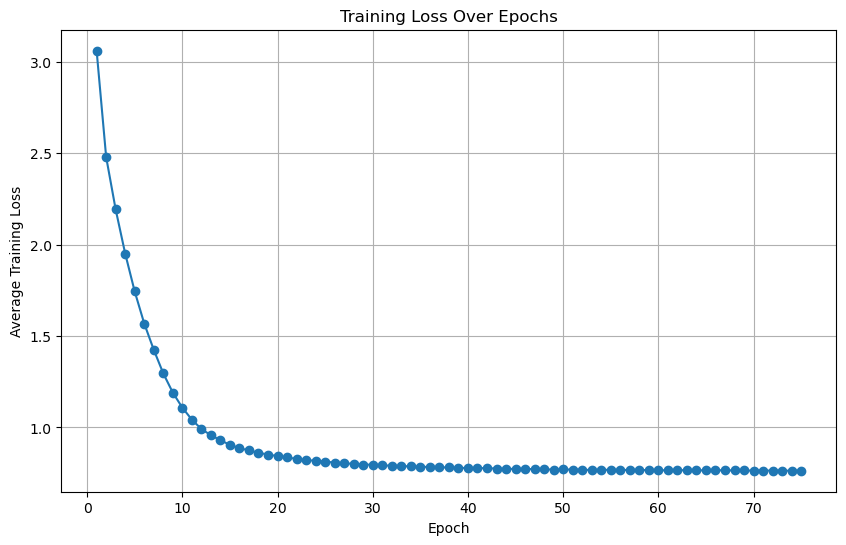

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/merges.txt',
 './fine_tuned_model/added_tokens.json')

In [10]:

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 75 + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

# Save the model
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

In [23]:
def generate_text(prompt, max_length=50):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.9
        )
    
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Test the model
test_prompt = "What did Irish Mehta say when he was depressed?"
generated_text = generate_text(test_prompt)
print(f"Generated text:\n{generated_text}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text:
What did Irish Mehta say when he was depressed?  reply= " depressive symptoms hai" and then heabhi again come back toPS. Positive aai nahi because of all the resources They have and all 3 cheeks.te


# GPT 2 based Chatbot using Past Conversation

## Preparing data

In [2]:
import re
import emoji

def preprocess_conversations(input_file, output_file):
    # Regular expressions for cleaning
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    media_pattern = r'<Media omitted>'
    
    def clean_message(message):
        # Remove URLs
        message = re.sub(url_pattern, '', message)
        
        # Remove emojis
        message = emoji.replace_emoji(message, '')
        
        # Remove media tags
        message = re.sub(media_pattern, '', message)
        
        # Clean up extra whitespace
        message = ' '.join(message.split())
        
        return message.strip()
    
    cleaned_conversations = []
    
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:  # Skip empty lines
                # Split into name and message
                try:
                    name, message = line.split(': ', 1)
                    
                    # Clean the message
                    cleaned_message = clean_message(message)
                    
                    # Only keep the line if there's actual content after cleaning
                    if cleaned_message:
                        cleaned_line = f"{name}: {cleaned_message}"
                        cleaned_conversations.append(cleaned_line)
                except ValueError:
                    # Skip malformed lines
                    continue
    
    # Write cleaned conversations to output file
    with open(output_file, 'w', encoding='utf-8') as f:
        for line in cleaned_conversations:
            f.write(line + '\n')

    return cleaned_conversations

# Example usage
input_file = './Datasets/chat_temp.txt'  # Your input file
output_file = './Datasets/cleaned_chats.txt'  # Where to save cleaned data

# First, install required package if not already installed
# !pip install emoji

# Process the conversations
cleaned_data = preprocess_conversations(input_file, output_file)

# Print sample of cleaned data
print("Sample of cleaned conversations:")
for line in cleaned_data[:5]:  # Show first 5 lines
    print(line)

Sample of cleaned conversations:
Lukha Saala: Bhau
Lukha Saala: Bhai
Lukha Saala: Thik hai tu?
Irish Mehta: Tensor flow kar raha
Irish Mehta: Regression seekha


In [19]:
import re
import emoji

def preprocess_conversations(input_file, output_file):
    # Regular expressions for cleaning
    timestamp_pattern = r'^\d{1,2}/\d{1,2}/\d{4},\s\d{1,2}:\d{2}\s-\s'
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    media_pattern = r'<Media omitted>'
    deleted_message_pattern = r'You deleted this message'
    
    def clean_message(message):
        # Remove URLs
        message = re.sub(url_pattern, '', message)
        
        # Remove emojis
        message = emoji.replace_emoji(message, '')
        
        # Remove media tags and deleted messages
        message = re.sub(media_pattern, '', message)
        message = re.sub(deleted_message_pattern, '', message)
        
        # Clean up extra whitespace
        message = ' '.join(message.split())
        
        return message.strip()
    
    def replace_name(name):
        # Replace names according to requirements
        if name.strip() == "Irish Mehta":
            return "BOT"
        elif name.strip() == "Lukha Saala":
            return "USER"
        return name.strip()
    
    cleaned_conversations = []
    current_message = ""
    current_name = ""
    
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:  # Skip empty lines
                # Check if line starts with timestamp
                if re.match(timestamp_pattern, line):
                    # Save previous message if exists
                    if current_message and current_name:
                        cleaned_message = clean_message(current_message)
                        if cleaned_message:
                            cleaned_line = f"{current_name}: {cleaned_message}"
                            cleaned_conversations.append(cleaned_line)
                    
                    # Remove timestamp
                    line = re.sub(timestamp_pattern, '', line)
                    
                    # Split into name and message
                    try:
                        name, message = line.split(': ', 1)
                        current_name = replace_name(name)
                        current_message = message
                    except ValueError:
                        current_message = line
                else:
                    # Append to current message (multiline message)
                    current_message += " " + line
    
    # Add the last message if exists
    if current_message and current_name:
        cleaned_message = clean_message(current_message)
        if cleaned_message:
            cleaned_line = f"{current_name}: {cleaned_message}"
            cleaned_conversations.append(cleaned_line)
    
    # Simply append cleaned conversations to output file
    with open(output_file, 'a', encoding='utf-8') as f:
        for line in cleaned_conversations:
            f.write(line + '\n')

    return cleaned_conversations

# Example usage
input_file = './Datasets/chat5.txt'  # Your input file
output_file = './Datasets/cleaned_chats.txt'  # Where to append cleaned data

# Process the conversations
cleaned_data = preprocess_conversations(input_file, output_file)

# Print sample of cleaned data
print("\nSample of cleaned conversations:")
for line in cleaned_data[:5]:  # Show first 5 lines
    print(line)


Sample of cleaned conversations:
USER: Bhau
USER: Bhai
USER: Thik hai tu?
BOT: Tensor flow kar raha
BOT: Regression seekha


In [29]:
with open('./Datasets/cleaned_chats.txt', 'r', encoding='utf-8') as file:
    # Read lines and strip whitespace
    cleaned_data = [line.strip() for line in file if line.strip()]
print(len(cleaned_data))

63692


In [19]:
## Ground Truth- Is the bot able to answer better before fine tuning than after?

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Set EOS token as padding token
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

# Move model to the appropriate device
model.to(device)

# Define a more specific and engaging prompt
prompt = "Can you answer in a mix of hindi and english? Aaj aap kaise ho?"
# Encode the input prompt
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# Generate text with more room for creativity
output = model.generate(
    input_ids, 
    max_length=50,  # Allow for longer, more developed responses
    min_length=20,  # Ensure responses are not too short
    num_return_sequences=1, 
    temperature=0.7,  # Encourage more creative and diverse output
    top_k=40,  # Narrow the candidate pool slightly
    top_p=0.9,  # Adjust nucleus sampling for more focused responses
    repetition_penalty=1.2,  # Further penalize repetition
    pad_token_id=tokenizer.pad_token_id,
)

# Decode and print the generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)


Can you answer in a mix of hindi and english? Aaj aap kaise ho?
I am not sure. I have heard that the word "hindi" is used to describe people who are very good at reading English,


## Attempt 1- Using padding and generic approach (Failed)

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW


class ChatDataset(Dataset):
    def __init__(self, conversations, target_user='BOT', max_length=32):
        self.samples = []
        self.max_length = max_length
        self.target_user = target_user
        self.tokenizer = tokenizer
        
        current_context = []
        
        for message in conversations:
            try:
                user, content = message.split(': ', 1)
                
                if user == self.target_user and current_context:
                    # Context is what others said
                    context_text = "[USER] " + " [USER] ".join(current_context)
                    
                    # Target is your response
                    target_text = content
                    
                    # Encode context (input)
                    context_encoded = tokenizer.encode_plus(
                        context_text,
                        max_length=self.max_length,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt'
                    )
                    
                    # Encode target (your response)
                    target_encoded = tokenizer.encode_plus(
                        target_text,
                        max_length=self.max_length,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt'
                    )
                    
                    input_ids = context_encoded['input_ids'].squeeze()
                    attention_mask = context_encoded['attention_mask'].squeeze()
                    target_ids = target_encoded['input_ids'].squeeze()
                    
                    self.samples.append((input_ids, target_ids, attention_mask))
                    current_context = []
                elif user != self.target_user:
                    current_context.append(content)
            except ValueError:
                continue

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    def preview_samples(self, num_samples=3):
        """
        Preview a specified number of training samples in human-readable format.
        """
        print(f"\nPreviewing {min(num_samples, len(self.samples))} training samples:\n")
        
        for i in range(min(num_samples, len(self.samples))):
            input_ids, target_ids, attention_mask = self.samples[i]
            
            # Decode input sequence (context)
            input_text = self.tokenizer.decode(input_ids[attention_mask == 1], skip_special_tokens=False)
            
            # Decode target sequence (your response)
            target_text = self.tokenizer.decode(target_ids, skip_special_tokens=False)
            
            print(f"Sample {i+1}:")
            print(f"Input (context):")
            print(f"  {input_text}")
            print(f"\nTarget (your response):")
            print(f"  {target_text}")
            print("\n" + "="*80 + "\n")


def collate_fn(batch):
    input_ids, labels, attention_masks = zip(*batch)
    return (
        torch.stack(input_ids),
        torch.stack(labels),
        torch.stack(attention_masks)
    )

def train_model(conversations, num_epochs=20):  # Increased epochs
    # Setup model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    
    model.to(device)
    # Initialize tokenizer with special handling for non-English text
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    model.config.pad_token_id = tokenizer.pad_token_id
    # Add special tokens including the pad token and conversation markers
    special_tokens = {
        'pad_token': '[PAD]',
        'additional_special_tokens': ['[USER]', '[BOT]', '[EOS]']
    }
    tokenizer.add_special_tokens(special_tokens)
    model.resize_token_embeddings(len(tokenizer))

    # Create dataset and dataloader
    dataset = ChatDataset(conversations)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
    
    dataset.preview_samples(5)
    
    # Training settings
    optimizer = AdamW(model.parameters(), lr=1e-5)  # Lower learning rate
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (input_ids, labels, attention_mask) in enumerate(dataloader):
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if batch_idx % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            model.save_pretrained(f"./chatbot_checkpoint_epoch_{epoch+1}")
            tokenizer.save_pretrained(f"./chatbot_checkpoint_epoch_{epoch+1}")

    return model

def generate_response(model, context, max_length=10):
    model.eval()
    
    # Prepare input
    context_text = f"[USER] {context}"
    input_ids = tokenizer.encode(context_text, return_tensors='pt').to(model.device)
    
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.3,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2,
            min_length=10,
            early_stopping=True
        )
    
    response = tokenizer.decode(output[0][input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

In [4]:
import torch
import gc

# Empty the cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

# Print GPU memory stats to verify
if torch.cuda.is_available():
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


# Example usage:
if __name__ == "__main__":

    
    print("Starting training...")
    model = train_model(cleaned_data)
    
    # Save the final model
    model.save_pretrained("./final_chatbot_model")
    tokenizer.save_pretrained("./final_chatbot_model")
    
    # Test the model
    print("\nTesting the chatbot:")
    test_contexts = [
        "Kidhar se seekh raha hai?",
        "Aaj kya kar raha hai?",
        "Project kaisa chal raha hai?"
    ]
    
    for context in test_contexts:
        response = generate_response(model, context)
        print(f"\nContext: {context}")
        print(f"Response: {response}")

GPU Memory allocated: 0.00 MB
GPU Memory cached: 0.00 MB
Starting training...

Previewing 5 training samples:

Sample 1:
Input (context):
  [USER]  Pehle tha chandigarh kab bana  [USER]  Phir chandigarh ka mp kaun h  [USER]  Phir

Target (your response):
  Ooo thanks[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


Sample 2:
Input (context):
  [USER]  Lol

Target (your response):
  In NC?[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


Sample 3:
Input (context):
  [USER]  Bol  [USER]  Nhi  [USER]  Room  [USER]  Tez ka number de apna

Target (your response):
  8652647097[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


Sample 4:
Input (context):
  [USER]  Wtf bhai  [USER]  Main in hun bhai  [USER]  Hamesha 

/home/ihmehta/.local/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Batch 0, Loss: 5.2702
Epoch 1, Batch 1000, Loss: 3.7829
Epoch 1, Batch 2000, Loss: 1.0404
Epoch 1, Batch 3000, Loss: 0.6802
Epoch 1, Batch 4000, Loss: 1.3004
Epoch 1, Batch 5000, Loss: 0.6182
Epoch 1, Batch 6000, Loss: 5.7066
Epoch 1, Batch 7000, Loss: 0.8267
Epoch 1/20, Average Loss: 2.4308
Epoch 2, Batch 0, Loss: 2.7649
Epoch 2, Batch 1000, Loss: 2.1753
Epoch 2, Batch 2000, Loss: 1.6567
Epoch 2, Batch 3000, Loss: 3.4202
Epoch 2, Batch 4000, Loss: 0.3978
Epoch 2, Batch 5000, Loss: 2.5567
Epoch 2, Batch 6000, Loss: 1.9454
Epoch 2, Batch 7000, Loss: 2.1931
Epoch 2/20, Average Loss: 2.1294
Epoch 3, Batch 0, Loss: 2.2032
Epoch 3, Batch 1000, Loss: 0.6088
Epoch 3, Batch 2000, Loss: 1.6909
Epoch 3, Batch 3000, Loss: 4.6606
Epoch 3, Batch 4000, Loss: 1.4148
Epoch 3, Batch 5000, Loss: 1.3275
Epoch 3, Batch 6000, Loss: 1.5896
Epoch 3, Batch 7000, Loss: 1.8059
Epoch 3/20, Average Loss: 2.0987
Epoch 4, Batch 0, Loss: 6.0838
Epoch 4, Batch 1000, Loss: 5.6248
Epoch 4, Batch 2000, Loss: 1.

/home/ihmehta/.local/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(



Context: Kidhar se seekh raha hai?
Response: u kkaga na halin a b

Context: Aaj kya kar raha hai?
Response: h hahiaoh ka me b n is, a

Context: Project kaisa chal raha hai?
Response: ah k me b the h to.,ahi


In [25]:
def generate_response(model, context, max_length=30):
    model.eval()
    
    # Match the exact training format with [USER] tag
    context_text = f"[USER] {context}"
    input_ids = tokenizer.encode(context_text, return_tensors='pt').to(model.device)
    
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.3,
            min_length=5,
            early_stopping=True
        )
    
    # Decode only the generated part, not including the input context
    response = tokenizer.decode(output[0][input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

context= "Kaisa hai bhai?"
response = generate_response(model, context)
print(f"\nContext: {context}")
print(f"Response: {response}")


Context: Kaisa hai bhai?
Response: a meaha toatainade kegau


## Attempt2- Gpt 2 written by gpt 4o

In [60]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_scheduler, BertTokenizer


# Use BERT multilingual tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Define special tokens
special_tokens = {
    "pad_token": "[PAD]",
    "eos_token": "[EOS]",
    "bos_token": "[BOS]",
    "additional_special_tokens": ["[USER]", "[BOT]"]
}
tokenizer.add_special_tokens(special_tokens)


class ChatDataset(Dataset):
    def __init__(self, conversations, target_user='BOT', max_length=128):
        """
        Prepares the dataset for fine-tuning. Combines consecutive user messages into one context
        and creates context-response pairs.
        """
        self.samples = []
        self.max_length = max_length
        self.target_user = target_user
        self.tokenizer = tokenizer

        current_context = []

        for message in conversations:
            try:
                # Ensure the message has the format "user: content"
                if ': ' not in message:
                    continue

                user, content = message.split(': ', 1)

                if user == self.target_user and current_context:
                    # Combine all previous user messages into context
                    context_text = "[USER] " + ". ".join(current_context)

                    # Target is the response from the target user
                    target_text = content

                    # Append the sample (context, target) to the dataset
                    self.samples.append((context_text, target_text))

                    # Clear context after processing
                    current_context = []
                elif user != self.target_user:
                    # Add consecutive user messages to the current context
                    current_context.append(content)
            except ValueError:
                # Skip malformed messages
                continue

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        raw_context, raw_response = self.samples[idx]

        # Tokenize context and response
        context_encoded = self.tokenizer(
            raw_context,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        response_encoded = self.tokenizer(
            raw_response,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return (
            context_encoded['input_ids'].squeeze(),
            response_encoded['input_ids'].squeeze(),
            context_encoded['attention_mask'].squeeze()
        )


    def preview_samples(self, num_samples=3):
        """
        Preview a specified number of training samples in human-readable format.
        """
        print(f"\nPreviewing {min(num_samples, len(self.samples))} training samples:\n")

        for i in range(min(num_samples, len(self.samples))):
            sample = self.samples[i]
            if len(sample) != 2:
                print(f"Skipping malformed sample at index {i}: {sample}")
                continue
            
            raw_context, raw_response = sample

            # Tokenize and decode context sequence
            context_encoded = self.tokenizer(
                raw_context,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            input_text = self.tokenizer.decode(
                context_encoded['input_ids'].squeeze(), 
                skip_special_tokens=True
            )
            
            # Tokenize and decode target sequence
            response_encoded = self.tokenizer(
                raw_response,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            target_text = self.tokenizer.decode(
                response_encoded['input_ids'].squeeze(), 
                skip_special_tokens=True
            )
            
            print(f"Sample {i+1}:")
            print(f"Input (context): {input_text}")
            print(f"Target (response): {target_text}")
            print("\n" + "="*80 + "\n")


def collate_fn(batch):
    input_ids, labels, attention_masks = zip(*batch)
    return (
        torch.stack(input_ids),
        torch.stack(labels),
        torch.stack(attention_masks)
    )

def train_model(conversations, num_epochs=120, batch_size=4, learning_rate=2e-5):
    # Setup model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token_id
    model.config.eos_token_id = tokenizer.eos_token_id
    model.to(device)

    # Create dataset and dataloader
    dataset = ChatDataset(conversations)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    dataset.preview_samples(5)
    # Training settings
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = num_epochs * len(dataloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Training loop with validation
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (input_ids, labels, attention_mask) in enumerate(dataloader):
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            attention_mask = attention_mask.to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()

            if batch_idx % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 20 == 0:
            model.save_pretrained(f"./chatbot_checkpoint_epoch_{epoch+1}")
            tokenizer.save_pretrained(f"./chatbot_checkpoint_epoch_{epoch+1}")

    return model


def generate_response(model, context, max_length=50):
    model.eval()

    context_text = f"[USER] {context}"
    input_encoded = tokenizer.encode_plus(
        context_text,
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    input_ids = input_encoded['input_ids'].to(model.device)
    attention_mask = input_encoded['attention_mask'].to(model.device)
    
    with torch.no_grad():
        output = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            min_length=10,  # Ensure longer responses
            no_repeat_ngram_size=3,
            do_sample=True,
            top_k=40,
            top_p=0.9,
            temperature=0.7,
            repetition_penalty=1.3,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            early_stopping=True,
        )
    
    response = tokenizer.decode(output[0][input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()



In [61]:
import torch
import gc

# Empty the cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

# Print GPU memory stats to verify
if torch.cuda.is_available():
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


# Example usage:
if __name__ == "__main__":

    
    print("Starting training...")
    model = train_model(cleaned_data)
    
    # Save the final model
    model.save_pretrained("./chatbot_model_v2")
    tokenizer.save_pretrained("./chatbot_model_v2")
    
    # Test the model
    print("\nTesting the chatbot:")
    test_contexts = [
        "Kidhar se seekh raha hai?",
        "Aaj kya kar raha hai?",
        "Project kaisa chal raha hai?"
    ]
    
    for context in test_contexts:
        response = generate_response(model, context)
        print(f"\nContext: {context}")
        print(f"Response: {response}")

GPU Memory allocated: 4421.41 MB
GPU Memory cached: 5832.00 MB
Starting training...

Previewing 5 training samples:

Sample 1:
Input (context): Pehle tha chandigarh kab bana. Phir chandigarh ka mp kaun h. Phir ml ki definition. Aur numpy panda kya h puchha. Company ka HR manager kaun h
Target (response): Ooo thanks


Sample 2:
Input (context): Lol
Target (response): In NC?


Sample 3:
Input (context): Bol. Nhi. Room. Tez ka number de apna
Target (response): 8652647097


Sample 4:
Input (context): Wtf bhai. Main in hun bhai. Hamesha se hi in tha. Add kar waapis
Target (response): Veg Schezwan noodles laana ek pls


Sample 5:
Input (context): Sirf veg schezwan la rha. Kar diya order
Target (response): Thanks


Epoch 1, Batch 0, Loss: 85.2059


/home/ihmehta/.local/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Batch 1000, Loss: 0.4865
Epoch 1, Batch 2000, Loss: 1.4556
Epoch 1, Batch 3000, Loss: 0.4670
Epoch 1/120, Average Loss: 0.8764
Epoch 2, Batch 0, Loss: 3.7966
Epoch 2, Batch 1000, Loss: 0.4598
Epoch 2, Batch 2000, Loss: 0.7969
Epoch 2, Batch 3000, Loss: 0.3330
Epoch 2/120, Average Loss: 0.6358
Epoch 3, Batch 0, Loss: 0.4349
Epoch 3, Batch 1000, Loss: 0.6837
Epoch 3, Batch 2000, Loss: 0.8425
Epoch 3, Batch 3000, Loss: 1.1549
Epoch 3/120, Average Loss: 0.6238
Epoch 4, Batch 0, Loss: 0.6430
Epoch 4, Batch 1000, Loss: 0.7056
Epoch 4, Batch 2000, Loss: 0.3881
Epoch 4, Batch 3000, Loss: 0.4438
Epoch 4/120, Average Loss: 0.6182
Epoch 5, Batch 0, Loss: 0.8780
Epoch 5, Batch 1000, Loss: 0.6687
Epoch 5, Batch 2000, Loss: 0.8238
Epoch 5, Batch 3000, Loss: 0.7882
Epoch 5/120, Average Loss: 0.6135
Epoch 6, Batch 0, Loss: 0.2877
Epoch 6, Batch 1000, Loss: 0.5271
Epoch 6, Batch 2000, Loss: 0.4627
Epoch 6, Batch 3000, Loss: 0.4694
Epoch 6/120, Average Loss: 0.6098
Epoch 7, Batch 0, Loss: 0.371

/home/ihmehta/.local/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:649: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(



Context: Kidhar se seekh raha hai?
Response: edited - "n chacc isho you with.

Context: Aaj kya kar raha hai?
Response: ##roping ur investment saayy saahod saa 2yn rakn

Context: Project kaisa chal raha hai?
Response: ##ication yaro by min 6 timele ye Total on investment


## Salesforce model

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    get_linear_schedule_with_warmup, 
    AdamW
)
import numpy as np
from tqdm import tqdm
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ChatDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.input_ids = []
        self.attention_masks = []
        self.labels = []
        
        # Read and process the data
        self.process_conversations(file_path)
        
    def process_conversations(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        current_user_context = []
        
        for i in range(len(lines)):
            line = lines[i].strip()
            if not line:
                continue
                
            if line.startswith("USER: "):
                user_message = line[6:]  # Remove "USER: " prefix
                current_user_context.append(user_message)
            
            elif line.startswith("BOT: "):
                bot_response = line[5:]  # Remove "BOT: " prefix
                if current_user_context:  # Only process if we have user context
                    # Combine all user messages with [USER] tags
                    combined_context = " [USER] ".join(current_user_context)
                    context_text = f"[USER] {combined_context}"
                    
                    # Encode the conversation pair
                    encoding = self.tokenizer(
                        context_text,
                        bot_response,
                        truncation=True,
                        max_length=self.max_length,
                        padding='max_length',
                        return_tensors='pt'
                    )
                    
                    self.input_ids.append(encoding['input_ids'].squeeze())
                    self.attention_masks.append(encoding['attention_mask'].squeeze())
                    
                    # Create labels (shift input_ids right by 1)
                    labels = encoding['input_ids'].clone()
                    labels[labels == self.tokenizer.pad_token_id] = -100
                    self.labels.append(labels.squeeze())
                
                current_user_context = []  # Reset context after BOT response
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

def train_model(train_dataset, val_dataset, model, tokenizer, 
                output_dir, num_epochs=5, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    
    model = model.to(device)
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size
    )
    
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
    
    # Set up learning rate scheduler
    num_training_steps = len(train_dataloader) * num_epochs
    num_warmup_steps = num_training_steps // 5  # 20% warmup
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
    
    # Training loop
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        # Training
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Validation
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                total_val_loss += outputs.loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        
        logger.info(f"Epoch {epoch+1}/{num_epochs}")
        logger.info(f"Average training loss: {avg_train_loss:.4f}")
        logger.info(f"Average validation loss: {avg_val_loss:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            
            # Save model and tokenizer
            logger.info("Saving best model...")
            model.save_pretrained(os.path.join(output_dir, 'best_model'))
            tokenizer.save_pretrained(os.path.join(output_dir, 'best_model'))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                logger.info("Early stopping triggered")
                break
    
    return model, tokenizer

def main():
    # Initialize model and tokenizer
    model_name = "microsoft/DialoGPT-medium-hi"  # Using Hindi-English bilingual model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    
    # Add special tokens
    special_tokens = {"additional_special_tokens": ["[USER]", "[BOT]"]}
    tokenizer.add_special_tokens(special_tokens)
    model.resize_token_embeddings(len(tokenizer))
    
    # Set pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id
    
    # Load and split data
    file_path = "./Datasets/cleaned_chats.txt"  # Replace with your file path
    output_dir = "output_model"  # Replace with desired output directory
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create dataset
    full_dataset = ChatDataset(file_path, tokenizer)
    
    # Split into train and validation
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )
    
    logger.info(f"Training samples: {train_size}")
    logger.info(f"Validation samples: {val_size}")
    
    # Train the model
    model, tokenizer = train_model(
        train_dataset,
        val_dataset,
        model,
        tokenizer,
        output_dir,
        num_epochs=5,
        batch_size=4
    )
    
    logger.info("Training completed!")

if __name__ == "__main__":
    main()